# Example notebook of single toyMC and associated outputs

In [1]:
from binference.likelihoods.ll_darwin import InferenceObject
from binference.utils import read_neyman_threshold

from blueice.inference import bestfit_scipy

import numpy as np
import scipy.stats as sps
from scipy.interpolate import interp1d
from inference_interface import toyfiles_to_numpy
import matplotlib.pyplot as plt
import pkg_resources

In [2]:
from binference.likelihoods.ll_darwin import minimize_kwargs

## Initialize Inference object

In [38]:
wimp_mass = 50
livetime = 200 #ty
wimp_masses = [10,50,200]
threshold_name = "darwin_test/thresholds.hdf5" #This is our Neyman result from the last notebook!

In [61]:
darwin_stat_model = InferenceObject(wimp_mass = 50,wimp_masses=wimp_masses,
                                    livetime=livetime, limit_threshold=threshold_name,
                                   )

loading limit_threshold darwin_test/thresholds.hdf5, confidence level 0.90
loaded threshold
signal_expectations [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40.]
thresholds [1.17791397 1.37116544 1.89307083 2.17975516 2.22702001 2.41919101
 2.70694569 2.81745561 2.87126797 2.7863489  2.78600802 2.83650848
 2.62920238 2.58696935 2.59300575 2.61825873 2.61541133 2.65000147
 2.77238566 2.82536442 3.00179431]
nominal_signal_expectation 44044.340941896146


Computing/loading models on one core: 100%|██████████| 3/3 [00:00<00:00, 365.80it/s]


In [53]:
for wimp_mass in wimp_masses:
    print(darwin_stat_model.get_mus(wimp_mass=wimp_mass)["signal"])

1.8221874369779172
44.044340941896166
19.144225101362217


## Generate a toyMC data set

In [41]:
generate_args = dict(
    signal_rate_multiplier=0.00, # in 1e-48 cm^2
    wimp_mass = 50,
    )

In [66]:
ancillary_measurements = darwin_stat_model.simulate_and_assign_measurements(generate_args=generate_args)
datas = darwin_stat_model.simulate_and_assign_data(generate_args=generate_args)

In [67]:
#Check best fit rate for various signal component
ancillary_measurements

{'er_rate_multiplier': 0.9786991912566496,
 'cevns_rate_multiplier': 1.0135397048256582,
 'atnu_rate_multiplier': 0.8673358002378724,
 'solarnu_rate_multiplier': 0.9833458849712341}

In [44]:
color_map = {0:"k",1:"pink",2:"cyan",3:"green",}

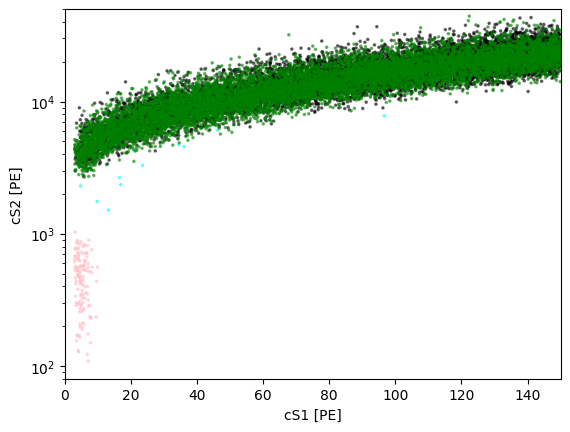

In [45]:
plt.clf()
sci_data = datas[0]
colors = [color_map[s] for s in sci_data["source"]]
plt.scatter(sci_data["cs1"],10**sci_data["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [PE]")
plt.yscale("log")
plt.ylabel("cS2 [PE]")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

#### Plot By Individual Source

In [31]:
er_events = sci_data[sci_data["source"]==0]
cevns_events = sci_data[sci_data["source"]==1]
atnu_events = sci_data[sci_data["source"]==2]
solar_events = sci_data[sci_data["source"]==3]

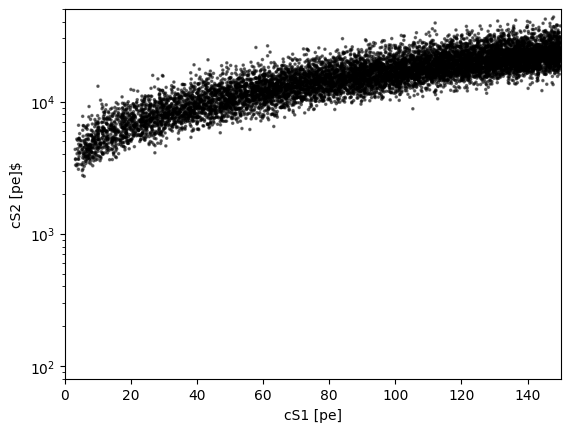

In [32]:
plt.clf()
colors = [color_map[s] for s in er_events["source"]]
plt.scatter(er_events["cs1"],10**er_events["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [pe]")
plt.yscale("log")
plt.ylabel("cS2 [pe]$")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

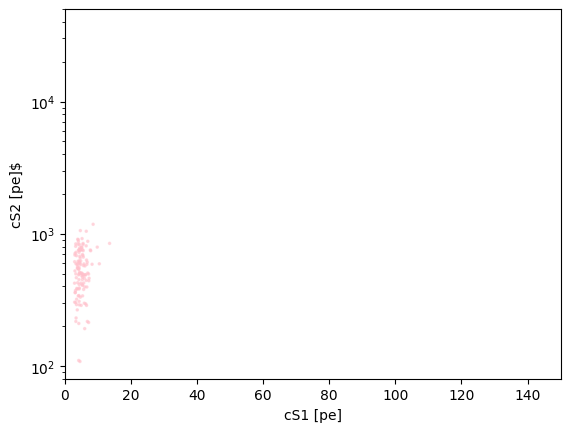

In [33]:
plt.clf()
colors = [color_map[s] for s in cevns_events["source"]]
plt.scatter(cevns_events["cs1"],10**cevns_events["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [pe]")
plt.yscale("log")
plt.ylabel("cS2 [pe]$")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

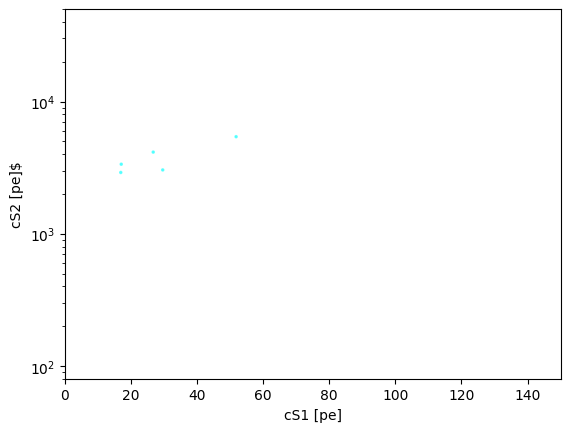

In [34]:
plt.clf()
colors = [color_map[s] for s in atnu_events["source"]]
plt.scatter(atnu_events["cs1"],10**atnu_events["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [pe]")
plt.yscale("log")
plt.ylabel("cS2 [pe]$")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

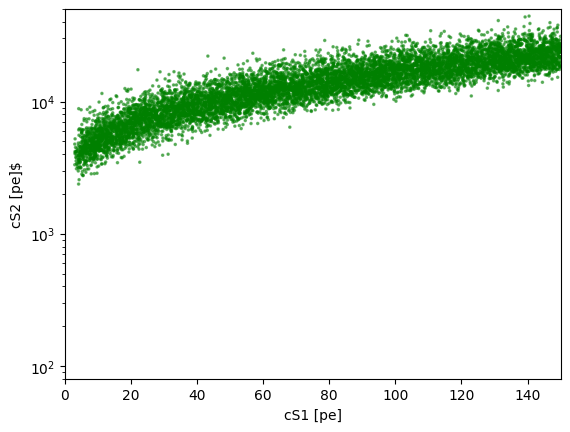

In [35]:
plt.clf()
colors = [color_map[s] for s in solar_events["source"]]
plt.scatter(solar_events["cs1"],10**solar_events["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [pe]")
plt.yscale("log")
plt.ylabel("cS2 [pe]$")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

## Fit our data/ excess:  

### Per-mass log-likelihood ratios:  

In [68]:
llrs = np.zeros(len(wimp_masses))
ll_wms = np.zeros(len(wimp_masses))
for i,wimp_mass in enumerate(wimp_masses): 
    res_wm, ll_wm = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, wimp_mass=wimp_mass)
    res_wm_null, ll_wm_null = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, 
                                            signal_rate_multiplier=0.,guess={"signal_rate_multiplier":0.},  wimp_mass=wimp_mass)
    llrs[i] = 2.* (ll_wm - ll_wm_null)
    ll_wms[i] = ll_wm
    

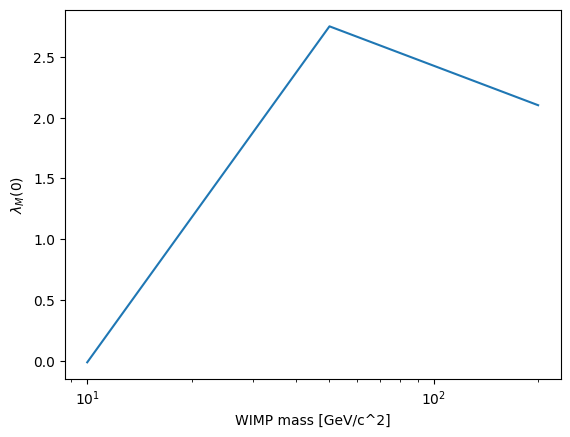

In [69]:
plt.clf()
plt.plot(wimp_masses, llrs)
plt.xscale("log")
plt.xlabel("WIMP mass [GeV/c^2]")
plt.ylabel("$\lambda_M(0)$")
plt.show()

### LLR values as function fo signal expectation

Note each toyMC only calculates LLR for given signal rate

In [105]:
signal_expectations = np.linspace(0, 40, 21)
llrs = np.zeros(len(signal_expectations))
ll_wms = np.zeros(len(signal_expectations))
s_rm = 0.01
wimp_mass = 50
for i,signal_expectation in enumerate(signal_expectations): 
    res_wm, ll_wm = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, wimp_mass=wimp_mass)
    res_wm_null, ll_wm_null = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, 
                                            signal_rate_multiplier=s_rm*signal_expectation,guess={"signal_rate_multiplier":s_rm*signal_expectation},  wimp_mass=wimp_mass)
    llrs[i] = 2.* (ll_wm - ll_wm_null)
    ll_wms[i] = ll_wm
    

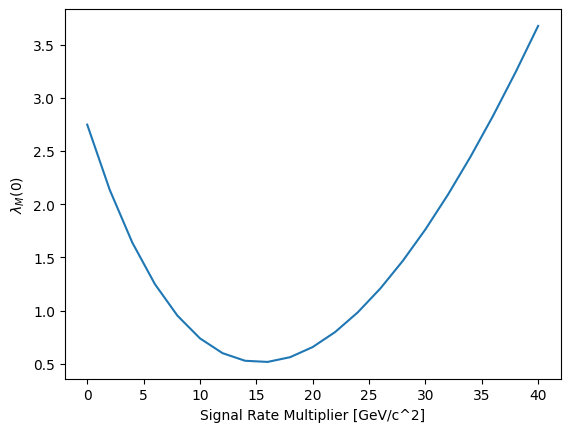

In [106]:
plt.clf()
plt.plot(signal_expectations, llrs)
plt.xlabel("Signal Rate Multiplier [GeV/c^2]")
plt.ylabel("$\lambda_M(0)$")
plt.show()